# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## **Загрузка библиотек**

In [1]:
import pandas as pd
import numpy as np
import torch
import transformers
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import math


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.dummy import DummyClassifier

from torch.utils.data import TensorDataset, random_split

import time
import datetime
import random


import pymorphy3
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist


import re
import wordcloud
from wordcloud import WordCloud


C:\Users\mary\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Подключение GPU**

In [2]:
if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070


# **Подготовка**

##   **Загрузка и изучение данных**

In [3]:
df_toxic_comment = pd.read_csv('https://code.s3.yandex.net//datasets/toxic_comments.csv')

In [4]:
df_toxic_comment.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df_toxic_comment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
df_toxic_comment.duplicated().sum()

0

In [7]:
df_toxic_comment ['text'].duplicated().sum()

0

In [8]:
df_toxic_comment = df_toxic_comment[df_toxic_comment.columns]
df_toxic_comment['num_nulls'] = df_toxic_comment[df_toxic_comment.columns].isnull().sum(axis=1)
df_toxic_comment.head()

,Unnamed: 0,text,toxic,num_nulls
0,0,Explanation\nWhy the edits made under my usern...,0,0
1,1,D'aww! He matches this background colour I'm s...,0,0
2,2,"Hey man, I'm really not trying to edit war. It...",0,0
3,3,"""\nMore\nI can't make any real suggestions on ...",0,0
4,4,"You, sir, are my hero. Any chance you remember...",0,0


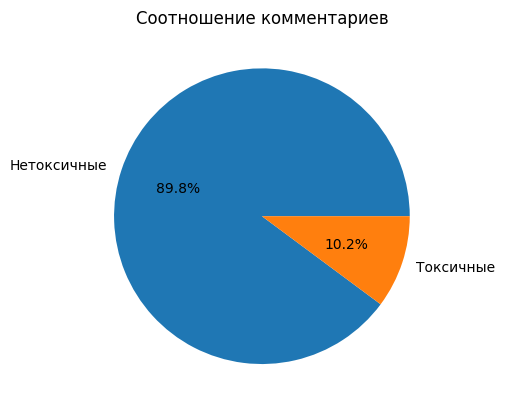

In [20]:
values = df_toxic_comment .groupby('toxic').size().to_list()
labels = ['Нетоксичные', 'Токсичные']
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Соотношение комментариев")
plt.ylabel("")
plt.show()

###  Частота слов в комметраниях без разделения на токсичные и нетоксичные

In [21]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mary\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mary\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mary\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
lemmatizer = WordNetLemmatizer()

def preprocess(text, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())  # токенизация
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks: # удаление знаков припенания
            lemma = lemmatizer.lemmatize(token) # лемматизация
            if lemma not in stop_words: # удаление стопслов
                preprocessed_text.append(lemma)
    return preprocessed_text

In [24]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '«', '»', ';', '–', '--', '*', '==', '#', ']', '[]', '{', '}','>', '<', '/', '|', '\" ', '\\', '\'', '``', '\'\'','a']
stop_words = stopwords.words("english")
morph = pymorphy3.MorphAnalyzer()

In [25]:
df_toxic_comment['Preprocessed_texts'] =  df_toxic_comment.apply(lambda row: preprocess(row['text'], punctuation_marks, stop_words, morph), axis=1)

In [26]:
words_comments = [word for word_list in df_toxic_comment['Preprocessed_texts'].values for word in word_list]

In [27]:
fdist = FreqDist(words_comments)

In [28]:
df_freq = pd.DataFrame(list(fdist.items()), columns=['word', 'freq'])

In [29]:
df_freq1 = df_freq.nlargest(50, 'freq').sort_values(by='freq', ascending=False)
df_freq1.head()

,word,freq
90,article,73161
44,'s,66555
8,n't,56983
21,page,56095
99,wikipedia,45294


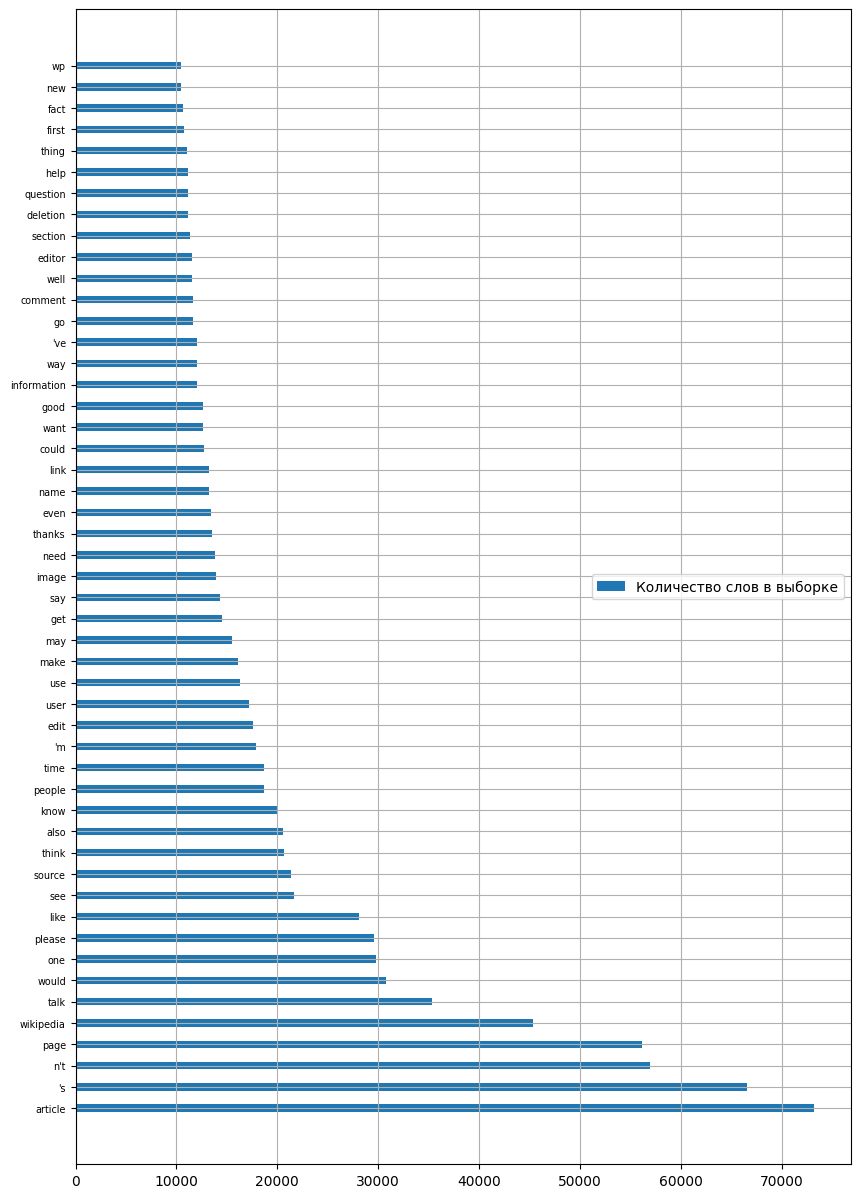

In [30]:
a_vals = df_freq1['freq']
ind = np.arange(df_freq1.shape[0])
width = 0.35

def autolabel(bars):
    # attach some text labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width*0.95, bar.get_y() + bar.get_height()/2,
                '%d' % int(width),
                ha='right', va='center')

# make the plots
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 15))
a = ax.barh(ind, a_vals, width) # plot a vals
ax.grid(True)
ax.set_yticks(ind)  # position axis ticks
ax.set_yticklabels(df_freq1['word'], fontsize = 'x-small')  # set them to the names
ax.legend(['Количество слов в выборке'], loc='center right')

plt.show()

In [31]:
fdists = [fdist]
titles = ['Количество слов в выборке']

for fdist, title in zip(fdists, titles):
    print(title)
    print('{:<12}{:<7}'.format('Слово', 'Частота'))
    for (word, freq) in fdist.most_common(10):
        print('{:<12}{:>5}'.format(word + ':', freq))
    print('\n')

Количество слов в выборке
Слово       Частота
article:    73161
's:         66555
n't:        56983
page:       56095
wikipedia:  45294
talk:       35329
would:      30737
one:        29798
please:     29596
like:       28079




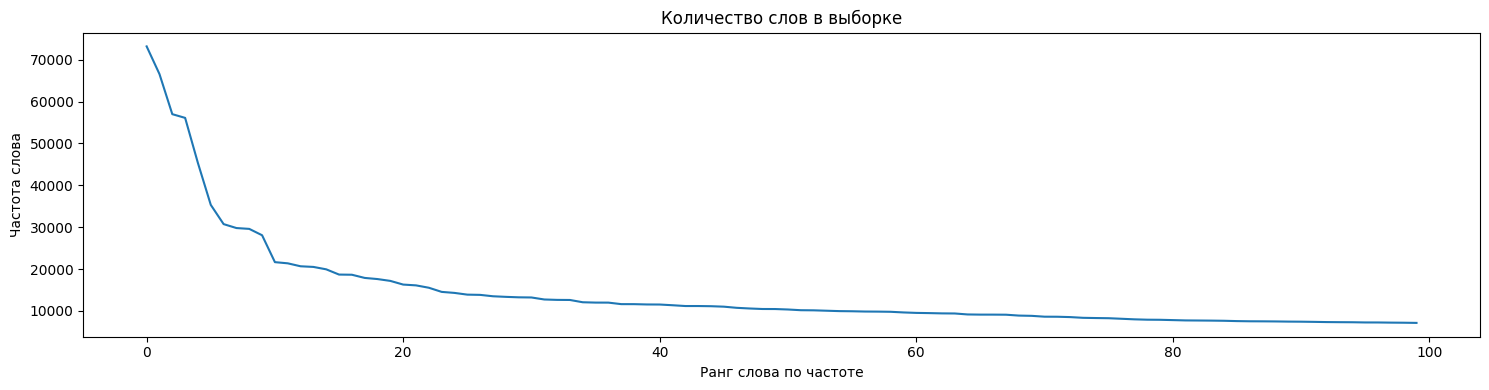

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

for i, (fdist, title) in enumerate(zip(fdists, titles)):
    ax.plot(sorted(fdist.values(), reverse=True)[:100])
    ax.set(xlabel='Ранг слова по частоте', ylabel='Частота слова', title=title)

plt.tight_layout()

###  Сравнение частоты слов в токсичных и нетоксичных комметраниях

Информативная визуализация для себя

In [33]:
words_comments_tox = [word for word_list in df_toxic_comment[df_toxic_comment['toxic'] == 1]['Preprocessed_texts'].values for word in word_list]
words_comments_sane = [word for word_list in df_toxic_comment[df_toxic_comment['toxic'] == 0]['Preprocessed_texts'].values for word in word_list]

In [34]:
fdist_tox = FreqDist(words_comments_tox)
fdist_sane = FreqDist(words_comments_sane)

In [35]:
df_tox = pd.DataFrame(list(fdist_tox.items()), columns=['word', 'freq'])
df_sane = pd.DataFrame(list(fdist_sane.items()), columns=['word', 'freq'])

In [36]:
df_tox['amount'] = df_tox['freq']
df_sane['amount'] = df_sane['freq']

In [37]:
df_tox1 = df_tox.nlargest(50, 'freq')

df_sane1 = df_sane.nlargest(50, 'freq')

df_freq_train = df_sane1.merge(df_tox1, on='word',how='outer', suffixes=('sane', 'tox'))

df_freq_train['largest'] = df_freq_train[df_freq_train.columns[[2,4]]].max(axis=1)

df_freq_train = df_freq_train.sort_values(by='largest', ascending=False)
df_freq_train.head()

,word,freqsane,amountsane,freqtox,amounttox,largest
5,article,71062.0,71062.0,2099.0,2099.0,71062.0
2,'s,62068.0,62068.0,4487.0,4487.0,62068.0
51,page,53270.0,53270.0,2825.0,2825.0,53270.0
45,n't,51016.0,51016.0,5967.0,5967.0,51016.0
78,wikipedia,41685.0,41685.0,3609.0,3609.0,41685.0


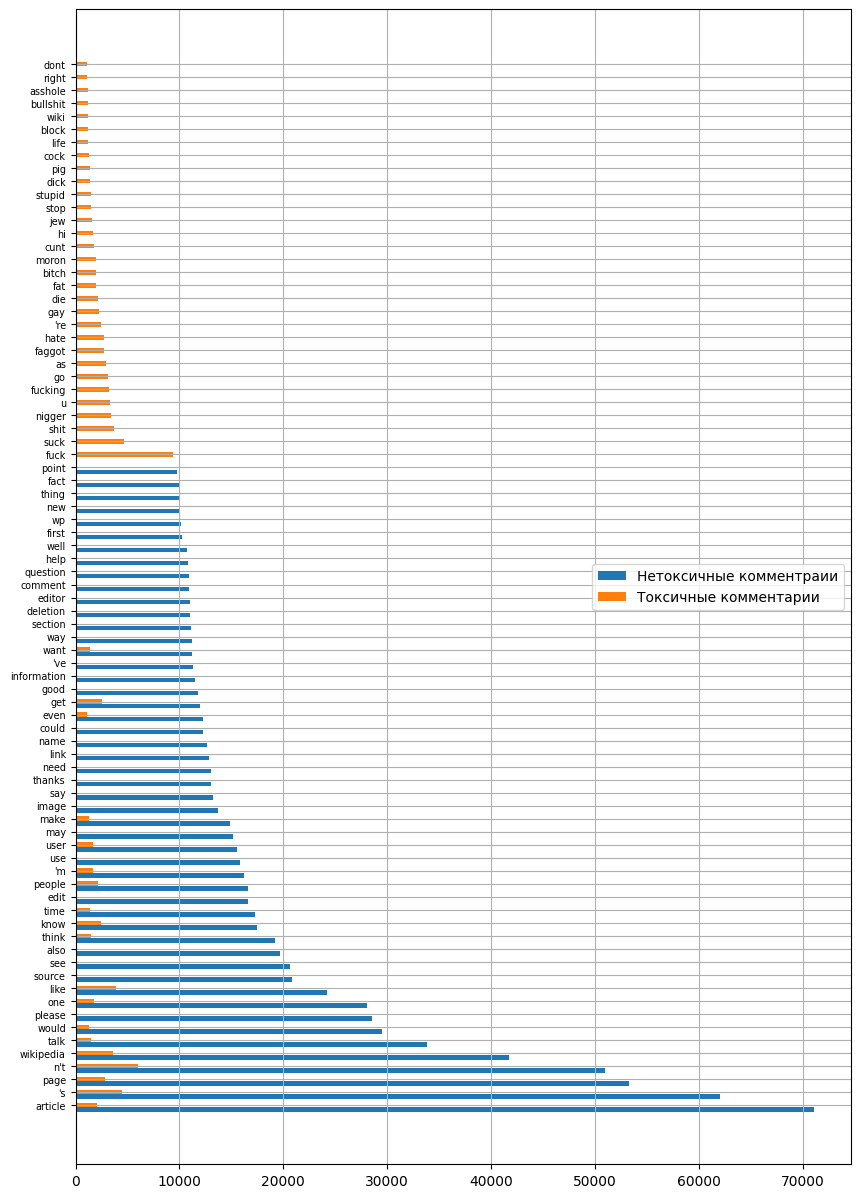

In [39]:
a_vals = df_freq_train['amountsane']
b_vals = df_freq_train['amounttox']
ind = np.arange(df_freq_train.shape[0])
width = 0.35

def autolabel(bars):
    # attach some text labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width*0.95, bar.get_y() + bar.get_height()/2,
                '%d' % int(width),
                ha='right', va='center')

# make the plots
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 15))
a = ax.barh(ind, a_vals, width) # plot a vals
b = ax.barh(ind + width, b_vals, width)  # plot b vals
ax.grid(True)
ax.set_yticks(ind + width)  # position axis ticks
ax.set_yticklabels(df_freq_train['word'], fontsize = 'x-small')  # set them to the names
ax.legend((a[0], b[0]), ['Нетоксичные комментраии', 'Токсичные комментарии'], loc='center right')

plt.show()

Красивая визуализация для клиентов

In [40]:
toxic_text = ' '.join(words_comments_tox)
clear_text = ' '.join(words_comments_sane)

In [41]:
cloud_params = {
    'max_words': 200,
    'regexp': '[a-z]+',
    'collocations': False,

    'width': 2400,
    'height': 1200,
    'margin': 5,

    'relative_scaling': 1,
    'prefer_horizontal': 1,
    'min_font_size': 20,
    'font_step': 2,

    'background_color': None,
    'mode': 'RGBA',

    'random_state': 42
}

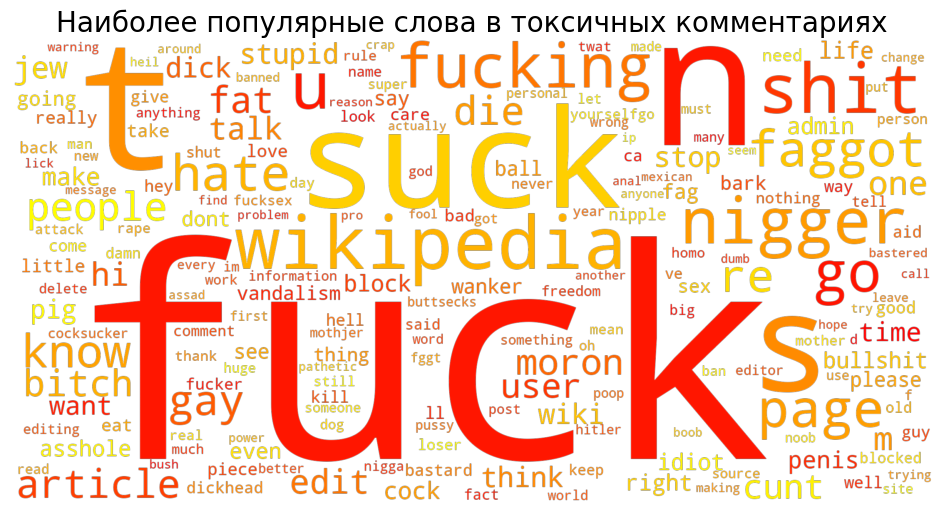

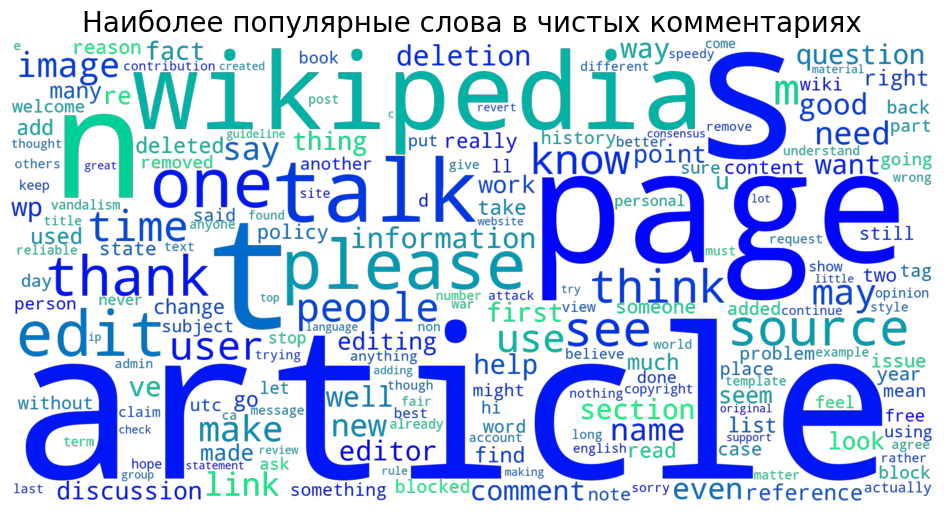

In [42]:
texts = [toxic_text, clear_text]
cmaps = ['autumn', 'winter']
titles = ['токсичных', 'чистых']

for text, cmap, title in zip(texts, cmaps, titles):
    word_cloud = WordCloud(colormap=cmap, **cloud_params)
    word_cloud.generate(text)
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.title('Наиболее популярные слова в {} комментариях'.format(title), fontsize=20)
    plt.imshow(word_cloud, interpolation='bilinear')
#     plt.imsave(title + '.png', word_cloud)

## **Вывод**
Дубликатов нет, пропусков нет, выборка несбалансирована

# **Обучение**

## Подготовка данных для обучения

In [49]:
df_toxic_comment1 = df_toxic_comment.sample(20000)

In [50]:
sentences = df_toxic_comment1.text.values

In [51]:
labels = df_toxic_comment1.toxic.values

#### Отделение тестовой выборки

In [52]:
sentences, sentences_test, labels, labels_test = train_test_split(
    sentences, labels, test_size=0.25, random_state=42, stratify=labels)

## Токенизация

In [53]:
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",do_lower_case = True)

In [54]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(sent,
                                         add_special_tokens = True,
                                         max_length = 512,
                                         truncation=True,
                                         padding='max_length',
                                         return_attention_mask = True,
                                         return_tensors = 'pt')

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

#### Преобразование списков в тензоры

In [55]:
input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [56]:
print('Original',sentences[42])
print('Token IDs', input_ids[42])

Original "

Hey Marnad1963, my only edit to the article was to change the words ""due to the fact"" to the word ""because"" using AutoWikiBrowser, a semi-automated wiki tool.
The content you quote isn't just one-sided or opinionated, it's just silly bragging. I've removed it. In situations like that, even if you have a conflict of interest, you are still free to get rid of it. The conflict of interest guidelines say that even if you have a conflict of interest, you are still free to sort out vandalism, spelling and grammar and so on. You haven't specified what your conflict of interest is though, so you might want to explain that on the talk page and/or your user page.
Hope that helps. If you've got any further questions or problems, feel free to either ask me or post on help desk. —  "
Token IDs tensor([  101,  1000,  4931,  9388, 25389, 16147,  2575,  2509,  1010,  2026,
         2069, 10086,  2000,  1996,  3720,  2001,  2000,  2689,  1996,  2616,
         1000,  1000,  2349,  2000, 

### Разделение тренировочной и валидационной выборки

In [57]:


# Объедините входные данные обучения в TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Разделение на тренировочную и валидационную выборку в соотношении 4/1

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


12,000 training samples
3,000 validation samples


In [58]:
# Задание размера пакета данных для DataLoader
batch_size = 16

# Создание DataLoader для обучающих набора в случайном порядке.
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

# Создание DataLoader для валидационного набора в последовательном порядке.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

## **Обучение модели**

In [59]:
model = BertForSequenceClassification.from_pretrained(
    "google-bert/bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [60]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [61]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )



In [62]:


epochs = 2

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [63]:


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [64]:


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
predictions, true_labels = [], []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        res= model(b_input_ids, 
                  token_type_ids=None, 
                  attention_mask=b_input_mask,
                  labels=b_labels)
            
        logits = res['logits']
        loss = res['loss']

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            res= model(b_input_ids, 
                   token_type_ids=None, 
                   attention_mask=b_input_mask,
                   labels=b_labels)
            
            logits = res['logits']
            loss = res['loss']
            
        total_eval_loss += loss.item()

        
        logits = logits.detach().cpu().numpy()
        pred_flat = np.argmax(logits, axis=1).flatten()
        pred_list = pred_flat.tolist()
        predictions = predictions + pred_list
                
        label_ids = b_labels.to('cpu').numpy()
        labels_flat = label_ids.flatten()
        labels_list = labels_flat.tolist()
        true_labels = true_labels + labels_list

   
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    f1_sc=f1_score(predictions, true_labels)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. f1_sc.': f1_sc,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))




======== Epoch 1 / 2 ========
Training...


C:\Users\mary\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  Batch    50  of    750.    Elapsed: 0:00:29.
  Batch   100  of    750.    Elapsed: 0:00:57.
  Batch   150  of    750.    Elapsed: 0:01:26.
  Batch   200  of    750.    Elapsed: 0:01:54.
  Batch   250  of    750.    Elapsed: 0:02:23.
  Batch   300  of    750.    Elapsed: 0:02:51.
  Batch   350  of    750.    Elapsed: 0:03:20.
  Batch   400  of    750.    Elapsed: 0:03:49.
  Batch   450  of    750.    Elapsed: 0:04:18.
  Batch   500  of    750.    Elapsed: 0:04:46.
  Batch   550  of    750.    Elapsed: 0:05:15.
  Batch   600  of    750.    Elapsed: 0:05:44.
  Batch   650  of    750.    Elapsed: 0:06:13.
  Batch   700  of    750.    Elapsed: 0:06:41.

  Average training loss: 0.16
  Training epcoh took: 0:07:10

Running Validation...
  Validation Loss: 0.12
  Validation took: 0:00:34

======== Epoch 2 / 2 ========
Training...
  Batch    50  of    750.    Elapsed: 0:00:29.
  Batch   100  of    750.    Elapsed: 0:00:58.
  Batch   150  of    750.    Elapsed: 0:01:26.
  Batch   200  of    7

In [65]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

df_stats = df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. f1_sc.,Training Time,Validation Time
epoch,,,,,
1,0.155319,0.124990,0.781065,0:07:10,0:00:34
2,0.067939,0.152134,0.784351,0:07:12,0:00:34


## Вывод
Метрика F1 на валидационной выборке больше 0,75. Модель предположительно обеспечивает требуемую точность

## **Тестирование модели**

In [66]:
input_ids = []
attention_masks = []

for sent in sentences_test:
    encoded_dict = tokenizer.encode_plus(sent,
                                         add_special_tokens = True,
                                         max_length = 256,
                                         truncation=True,
                                         padding='max_length',
                                         return_attention_mask = True,
                                         return_tensors = 'pt')

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

In [67]:
input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels_test)

In [68]:
batch_size = 16

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [69]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))


model.eval()

predictions, true_labels = [], []
total_eval_accuracy = 0


for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                          attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()


    pred_flat = np.argmax(logits, axis=1).flatten()
    pred_list = pred_flat.tolist()
    predictions = predictions + pred_list
                

    labels_flat = label_ids.flatten()
    labels_list = labels_flat.tolist()
    true_labels = true_labels + labels_list

f1_sc=f1_score(predictions, true_labels)
print("f1_score: {0:.2f}".format(f1_sc))


Predicting labels for 5,000 test sentences...
f1_score: 0.85


## Вывод
Метрика F1 на тестовой выборке больше 0,75. Модель обеспечивает требуемую точность

## **Проверка адекватности модели**

In [70]:
dummy_clf = DummyClassifier(strategy = 'constant', constant = 1)
dummy_clf.fit(input_ids, labels_test)
dummy_prections = dummy_clf.predict(input_ids)

dummy_prections_df = pd.DataFrame(dummy_prections)
print(dummy_prections_df.value_counts())

f1_dummy  = f1_score(labels_test, dummy_prections)

print("f1 на тестовой выборке:", f1_dummy)


0
1    5000
Name: count, dtype: int64
f1 на тестовой выборке: 0.18709209572153734


## Вывод
Метрика F1 на тестовой для случайного классификатора значительно ниже метрики модели BERT. Модель можно считать адекватной

# **Выводы**

In [71]:
print('За основу проекта был взят вариант https://mccormickml.com/2019/07/22/BERT-fine-tuning/ с исправлением метрики точности на метрику F1 и заменой устраревших методов')
print(f'Модель обеспечивает точность на тествой выборке {f1_sc:.2f}, что превышает требуемое значение 0.75' )
print(f'Метрика F1 случайного предсказателя составлеят {f1_dummy:.2f} что  значительно ниже метрики модели BERT. Модель можно считать адекватной' )

За основу проекта был взят вариант https://mccormickml.com/2019/07/22/BERT-fine-tuning/ с исправлением метрики точности на метрику F1 и заменой устраревших методов
Модель обеспечивает точность на тествой выборке 0.85, что превышает требуемое значение 0.75
Метрика F1 случайного предсказателя составлеят 0.19 что  значительно ниже метрики модели BERT. Модель можно считать адекватной


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны